See [resampling_tensors.ipynb](resampling_tensors.ipynb) for some more details on the early parts

In [2]:
import multiprocessing
from pathlib import Path
from copy import deepcopy
from collections import Counter

import numpy as np

from astropy import units as u
from astropy import constants as cnst
from astropy.io import fits
from astropy import modeling, table

from astroquery.svo_fps import SvoFps

from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [3]:
datapath = Path('../fullgrid/')

In [4]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
model_wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

model_wls, len(model_wls)

(<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>,
 1569128)

In [4]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

In [5]:
goodspecpaths = []
for pth in allspecpaths:
    h = fits.getheader(pth)
    if 'BUNIT' in h:
        specunit = h['BUNIT']
        goodspecpaths.append(pth)
specunit = u.Unit(specunit)
len(goodspecpaths)

7508

This wavelength is roughly covering the NIRSpec data at ~ 2x oversampling

# Experiment with a single spectrum

In [176]:
solarish_pth = [p for p in goodspecpaths if '5800-4.50-0.0' in str(p)][0]
solarish_pth

PosixPath('../fullgrid/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

In [177]:
header = dict(fits.getheader(solarish_pth))
header

{'SIMPLE': True,
 'BITPIX': -32,
 'NAXIS': 1,
 'NAXIS1': 1569128,
 'EXTEND': True,
 'EXTNAME': 'PRIMARY',
 'WAVE': '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits',
 'PHXTEFF': 5800.0,
 'PHXLOGG': 4.5,
 'PHXM_H': 0.0,
 'PHXALPHA': 0.0,
 'PHXDUST': False,
 'PHXEOS': 'ACES',
 'PHXBUILD': '02/Aug/2010',
 'PHXVER': '16.01.00B',
 'DATE': '2012-08-27 16:20:10',
 'PHXXI_L': 0.97,
 'PHXXI_M': 0.97,
 'PHXXI_N': 0.97,
 'PHXMASS': 2.0097e+33,
 'PHXREFF': 65120000000.0,
 'PHXLUM': 3.4194e+33,
 'PHXMXLEN': 1.58851928542,
 'BUNIT': 'erg/s/cm^2/cm'}

In [178]:
spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(solarish_pth, ext=0) << specunit)

In [179]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

In [180]:
transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [181]:
tab = transmission['F814W']

In [182]:
%%time

resampler = manipulation.FluxConservingResampler()
newspec = resampler(spec, tab['Wavelength'].quantity)

CPU times: user 189 ms, sys: 1.98 ms, total: 191 ms
Wall time: 189 ms


STmags can be treated as a source with a constant value of 1 of the below in flamb

In [248]:
(1*u.STflux).to(u.erg/u.s * u.cm**-2 / u.angstrom)

<Quantity 3.63078055e-09 erg / (Angstrom s cm2)>

In [238]:
lamb = tab['Wavelength'].quantity
dlamb = np.gradient(lamb)
denominator = np.sum(lamb* (np.array(tab['Transmission']) << u.STflux) * dlamb)
numerator = np.sum(lamb* np.array(tab['Transmission'])*newspec.flux * dlamb)

sb_in_band = (numerator/denominator)
sb_in_band.decompose()

<Quantity 1.40214461e+15>

In [239]:
absflux = sb_in_band * ((header['PHXREFF'] * u.cm)/(10*u.pc))**2
absmag = -2.5*np.log10(absflux)
absmag

<Quantity 5.51119875>

In [240]:
((header['PHXLUM']*u.erg/u.s)/u.solLum).decompose()

<Quantity 0.89326019>

In [241]:
-2.5*np.log10((header['PHXLUM']*u.erg/u.s)/u.solLum)

<Quantity 0.12255505>

a bit off from  what one might expect but this is probably an STmag effect? Try vegamags

In [242]:
vega_calspec = fits.open('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/alpha_lyr_mod_004.fits')
vega_wl = vega_calspec[1].data['WAVELENGTH'] * u.angstrom
vega_flux = vega_calspec[1].data['FLUX'] * (u.erg/u.s * u.cm**-2 / u.angstrom)
vegaspec = Spectrum1D(spectral_axis=vega_wl, flux=vega_flux)

In [245]:
newvega = resampler(vegaspec, tab['Wavelength'].quantity)
denominatorv = np.sum(lamb * np.array(tab['Transmission']) * newvega.flux * dlamb)
absfluxv = (numerator/denominatorv) * ((header['PHXREFF'] * u.cm)/(10*u.pc))**2
absmagv = -2.5*np.log10(absfluxv)
absmagv

<Quantity 4.24496904>

4.11 is sun according to https://mips.as.arizona.edu/~cnaw/sun_2006.html so this is right on for the lum ratio.  Check ABmags

In [256]:
ABspec = Spectrum1D(spectral_axis=tab['Wavelength'].quantity, flux=np.ones(len(tab))*u.ABflux)
ABspecinflamb = ABspec.with_flux_unit(spec.flux.unit)

denominatorab = np.sum(lamb * np.array(tab['Transmission']) * ABspecinflamb.flux * dlamb)
absfluxab = (numerator/denominatorab) * ((header['PHXREFF'] * u.cm)/(10*u.pc))**2
absmagab = -2.5*np.log10(absfluxab)
absmagab

<Quantity 4.67547771>

vs 4.53 so again within 10s of millimags lets use vega since I think that's PHAT?

# Compute and save

In [261]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

In [262]:
transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [265]:
vega_calspec = fits.open('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/alpha_lyr_mod_004.fits')
vega_wl = vega_calspec[1].data['WAVELENGTH'] * u.angstrom
vega_flux = vega_calspec[1].data['FLUX'] * (u.erg/u.s * u.cm**-2 / u.angstrom)
vegaspec = Spectrum1D(spectral_axis=vega_wl, flux=vega_flux)

vega_denominators = {}
AB_denominators = {}
STmag_denominators = {}
for filtername, tab in transmission.items():
    lamb = tab['Wavelength'].quantity
    dlamb = np.gradient(lamb)
    
    revega = resampler(vegaspec, tab['Wavelength'].quantity)
    vega_denominator = np.sum(lamb * np.array(tab['Transmission']) * revega.flux * dlamb)
    vega_denominators[filtername] = vega_denominator

    ABspec = Spectrum1D(spectral_axis=tab['Wavelength'].quantity, flux=np.ones(len(tab))*u.ABflux)
    ABspecinflamb = ABspec.with_flux_unit(spec.flux.unit)
    denominatorab = np.sum(lamb * np.array(tab['Transmission']) * ABspecinflamb.flux * dlamb)
    AB_denominators[filtername] = denominatorab

    STdenominator = np.sum(lamb * np.array(tab['Transmission']) * u.STflux * dlamb)
    STmag_denominators[filtername] = STdenominator

In [289]:
def spectrophotometer_spec(specpath):
    header = dict(fits.getheader(specpath, ext=0))
    spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(specpath, ext=0) << u.Unit(header['BUNIT']))
    results = {}
    
    for filtername, tab in transmission.items():
        lamb = tab['Wavelength'].quantity
        dlamb = np.gradient(lamb)
        newspec = resampler(spec, lamb)
        numerator = np.sum(lamb * np.array(tab['Transmission']) * newspec.flux * dlamb)

        numeratorscaled = numerator * ((header['PHXREFF'] * u.cm)/(10*u.pc))**2

        results[f'absmag_{filtername}_vega'] = -2.5*np.log10((numeratorscaled/vega_denominators[filtername]).to(u.dimensionless_unscaled).value)
        results[f'absmag_{filtername}_AB'] = -2.5*np.log10((numeratorscaled/AB_denominators[filtername]).to(u.dimensionless_unscaled).value)
        results[f'absmag_{filtername}_ST'] = -2.5*np.log10((numeratorscaled/STmag_denominators[filtername]).to(u.dimensionless_unscaled).value)

    return {k:float(v)for k,v in results.items()}
        

In [290]:
spectrophotometer_spec(solarish_pth)

{'absmag_F275W_vega': 6.862130067229456,
 'absmag_F275W_AB': 8.369065706404227,
 'absmag_F275W_ST': 6.841291969777173,
 'absmag_F336W_vega': 5.548953927094908,
 'absmag_F336W_AB': 6.697181253054342,
 'absmag_F336W_ST': 5.63322549730218,
 'absmag_F475W_vega': 5.33670063216428,
 'absmag_F475W_AB': 5.233205639129073,
 'absmag_F475W_ST': 4.923222497619185,
 'absmag_F814W_vega': 4.24496904474627,
 'absmag_F814W_AB': 4.675477708523453,
 'absmag_F814W_ST': 5.511198746188787,
 'absmag_F110W_vega': 3.9145048338232806,
 'absmag_F110W_AB': 4.691272623523509,
 'absmag_F110W_ST': 6.309206428116663,
 'absmag_F160W_vega': 3.5106505110649717,
 'absmag_F160W_AB': 4.784940763124024,
 'absmag_F160W_ST': 7.026306095922487}

In [317]:
with multiprocessing.Pool(16) as pool:
      results = list(tqdm(pool.imap(spectrophotometer_spec, goodspecpaths), total=len(goodspecpaths)))
len(results)

  0%|          | 0/7508 [00:00<?, ?it/s]

: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]WARNINGWARNING: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]
: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]




: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]


: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]
WARNING

: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard [astropy.units.format.generic]: UnitsWarning: 'erg/s/cm^2/cm' contains multiple 

7508

In [318]:
colnames = ['specname'] + list(results[0].keys())
columns = {nm: [] for nm in colnames}
for pth, result in zip(goodspecpaths, results):
    row = []
    for colnm, col in columns.items():
        if colnm == 'specname':
            col.append(pth.name.split('.PHOENIX')[0])
        else:
            col.append(result[colnm])
    rows.append(row)

CPU times: user 18.6 ms, sys: 1.71 ms, total: 20.3 ms
Wall time: 25 ms


In [320]:
tab = table.Table(columns)
tab.write('spectrophotometry.ecsv', format='ascii.ecsv')

# some quick analysis

In [5]:
tab = table.Table.read('spectrophotometry.ecsv')

In [19]:
teff = np.array([float(nm[3:8]) for nm in tab['specname']])
logg = np.array([float(nm[9:13]) for nm in tab['specname']])
feh = np.array([float(nm[13:18]) for nm in tab['specname']])

In [44]:
teff

array([ 2300.,  2300.,  2300., ..., 12000., 12000., 12000.], shape=(7508,))

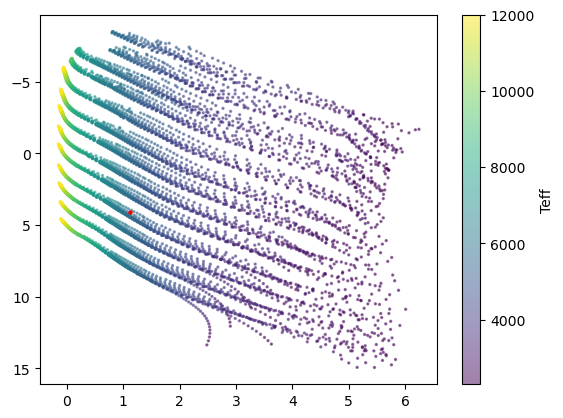

In [46]:
plt.scatter(tab['absmag_F475W_vega'] - tab['absmag_F814W_vega'], tab['absmag_F814W_vega'], c=teff, s=2, alpha=.5)
plt.colorbar().set_label('Teff')
plt.scatter([1.11], [4.11], c='red', s=10, lw=0) # sun according to https://mips.as.arizona.edu/~cnaw/sun.html
plt.ylim(*plt.ylim()[::-1]);

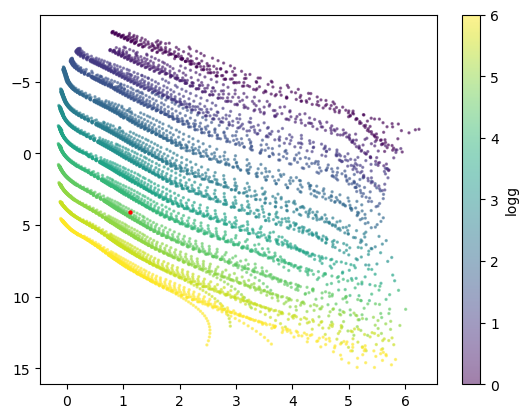

In [47]:
plt.scatter(tab['absmag_F475W_vega'] - tab['absmag_F814W_vega'], tab['absmag_F814W_vega'], c=logg, s=2, alpha=.5)
plt.colorbar().set_label('logg')
plt.scatter([1.11], [4.11], c='red', s=10, lw=0) # sun according to https://mips.as.arizona.edu/~cnaw/sun.html
plt.ylim(*plt.ylim()[::-1]);

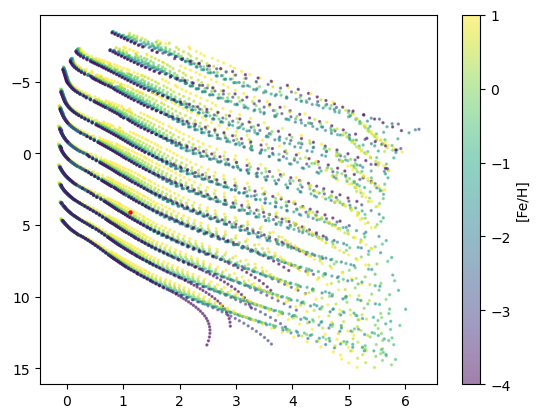

In [48]:
plt.scatter(tab['absmag_F475W_vega'] - tab['absmag_F814W_vega'], tab['absmag_F814W_vega'], c=feh, s=2, alpha=.5)
plt.colorbar().set_label('[Fe/H]')
plt.scatter([1.11], [4.11], c='red', s=10, lw=0) # sun according to https://mips.as.arizona.edu/~cnaw/sun.html
plt.ylim(*plt.ylim()[::-1]);

Text(0, 0.5, 'Teff')

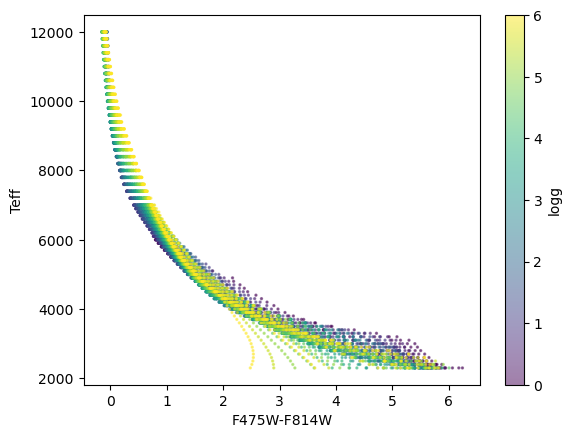

In [52]:
plt.scatter(tab['absmag_F475W_vega'] - tab['absmag_F814W_vega'], teff, c=logg, s=2, alpha=.5)
plt.colorbar().set_label('logg');
plt.xlabel('F475W-F814W')
plt.ylabel('Teff')